<center><img src="https://d.newsweek.com/en/full/1859515/screengrab-titanic-movie.jpg" width=500></center>

<h1><center>🛥️ Titanic - Machine Learning from Disaster 🛥️</center></h1>

# 1. Introduction

The sinking of the Titanic is one of the most infamous shipwrecks in history. 🧊🛥️

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, certain groups of people were more likely to survive than others, and while some passenger's hearts would go on... not everyone's did, sorry jack!  💔

### Libraries 📚⬇

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 2. The .csv files 📁

> 📌**Note**:
* `train.csv` contains the outcome for each passenger. It contains datapoints in  unique columns.
* `test.csv` does not contain the outcome for each passenger. This will be used to see how well our model performs on unseen data.
* `gender_submission.csv` servers as an example of what the submission file should look like. 

<div class="alert alert-block alert-info">
<b>Note:</b> I had previously run Pandas Profiling <code>df.profile_report()</code> to create a basic report on the input <code>train.csv</code> DataFrame. This is similar to using <code>df.describe()</code> but provides some more information fairly quickly. By running this I was able to see that. The Age column has <b>177 (19.9%)</b> missing values and Cabin has <b>687 (77.1%)</b> missing values. For this notebook I've left Pandas Profiling out, but provided a link below for anyone who wants to learn more. 
</div>
 
### Links 🔗
* [Pandas Profiling](https://pandas-profiling.ydata.ai/docs/master/index.html)

In [2]:
# Import train and test data
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
gender_submission = pd.read_csv("../input/titanic/gender_submission.csv")

### train.csv - let's take a look at the DataFrames first, then types
> 📌**Note**:
* `df.head()`: Check to make sure the data looks correct in both train & test
* `df.dtypes`: Check to see the data types in both train & test
* `gender_submission.head()`: Check to see what the submission data should look like
*  Make note that columns Sex, Cabin & Embarked may need to be converted from a `string` to an `int`

In [3]:
# Explore the format
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

# Explore the head of the dataframe
train.head()

Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 3. Data Preprocessing 🧼

There are many techniques that can be performed during this phase. Some of them are:

* checking for missing data
* analysis of the distributions and patterns in the data
* creating new features from the existing data (feature engineering)
* encoding the categorical features
* etc.

### Other helpful exploratory data analysis
* `train.columns`: Check the name of the columns
* `train.shape`: Check the shape of the columns
* `train.isnull().sum()`: Check to see which columns have missing data


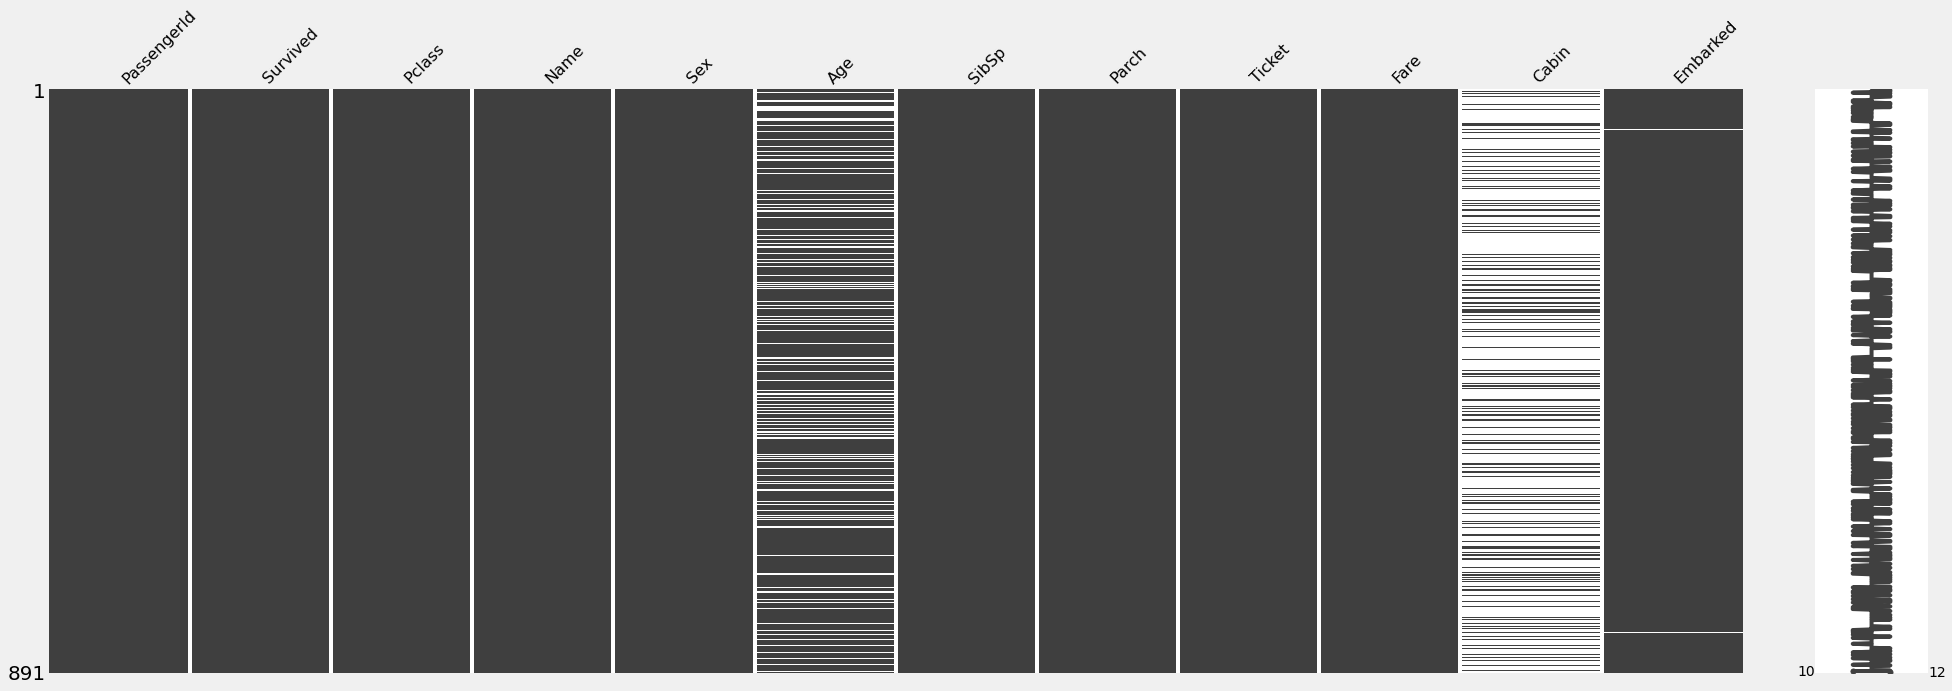

In [4]:
# Check for missing values
train.isnull().sum()
# Plot graphic of missing values
missingno.matrix(train, figsize = (30,10));

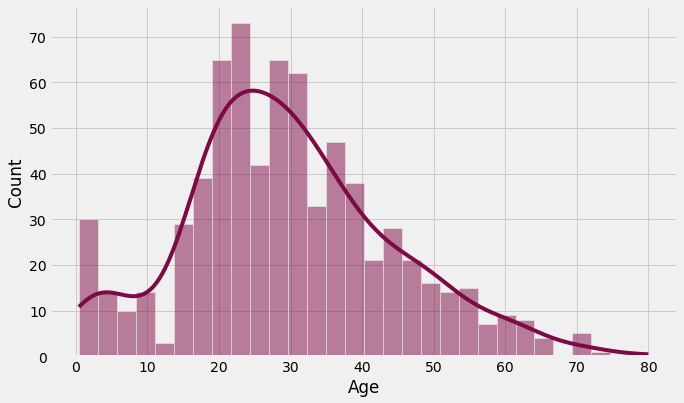

In [5]:
# Histogram of passenger ages.
plt.figure(figsize=(10,6))
sns.histplot(train['Age'].dropna(),bins=30, palette='inferno', color='#7D0A45', alpha=0.5, kde=True);

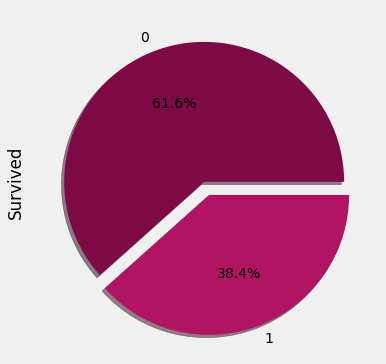

In [6]:
# Visualize the survival states
plt.figure(figsize=(10,6))
train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', shadow=True, colors=['#7D0A45', '#B11463']);

#### Imputation?

We know that Age and Cabin columns have some missing data, how should we think about resolving that issue? The two most common methods would be to remove the data -- or use imputation. 

> Imputation is a technique that replaces missing values in the data with another value (like the mean, median, mode, or other more complex operations). Be weary of the bias!

For Age, we'll use imputation

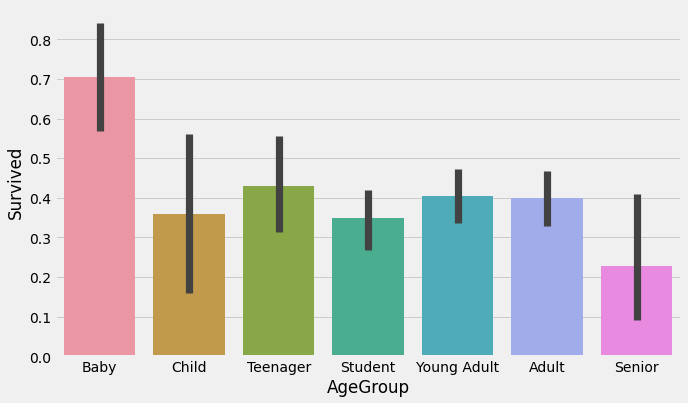

In [7]:
# Age had a lot of missing values, so we will need to fill in that data. 
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)

# We can also sort ages into categories
bins = [0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels = labels)

# Draw a bar plot of age vs. survival
plt.figure(figsize=(10,6))
sns.barplot(x="AgeGroup", y="Survived", data=train)
plt.show();

In [8]:
# We can drop the AgeGroup column now as we were using it to view the data above
train = train.drop(['AgeGroup'], axis = 1)
test = test.drop(['AgeGroup'], axis = 1)

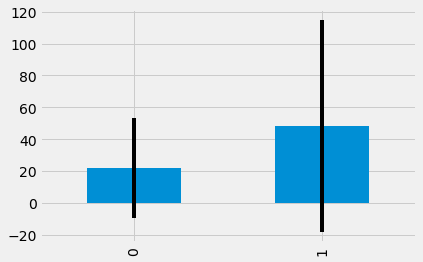

In [9]:
# We can see if there is a coorelation between fare price and survival rate
fare_not_survived = train['Fare'][train['Survived'] == 0]
fare_survived = train['Fare'][train['Survived'] == 1]

average_fare = pd.DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = pd.DataFrame([fare_not_survived.std(), fare_survived.std()])
average_fare.plot(yerr=std_fare, kind='bar', legend=False)

plt.show();

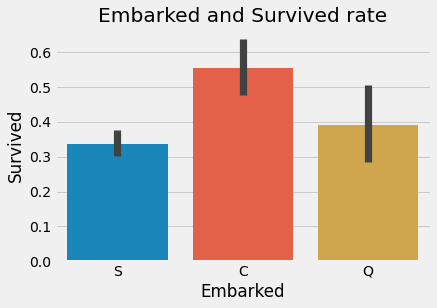

In [10]:
# We can also view if where passengers embarked from played a role in their survival
sns.barplot(x="Embarked", y="Survived", data=train)
plt.title('Embarked and Survived rate');
plt.show();

#### Fare & Embarked

From the above data we can see some interesting points. 

* Passengers with a higher fare tended to have a better chance of survival
* Passengers who embarked from Cherbourg had the highest chance of survival, and those from Southampton the least chance to survive. This is likley due to some socialeconomic differences and which part of the ship these passengers stayed in.

In [11]:
# Create a combined group of our Train and Test data
combine = [train, test]

# Extract a title for each Name in the train and test datasets
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [12]:
# Replace various titles with more common names
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


In [13]:
for dataset in combine:
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [14]:
# We'll drop the name feature for this analysis. While we could potentially find some data from this, for the purposes of this exercise we will not use this data
train = train.drop(['Name'], axis = 1)
test = test.drop(['Name'], axis = 1)

In [15]:
# We mentioned earlier that Sex would need to be changed to and int
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,1.0
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,3.0
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2.0
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,S,3.0
4,5,0,3,0,35.0,0,0,373450,8.0500,NaN,S,1.0


#### Predict Missing Ages

Next we'll fill in the missing values in the Age feature. Since a higher percentage of values are missing, it would be illogical to fill all of them with the same value. Instead, we will try to predict the missing ages.

In [16]:
# Calculate the correlation between features
train_corr = train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
train_corr[train_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
7,Age,Age,1.000000
19,Age,Pclass,0.360547
34,Age,SibSp,0.183470
41,Age,Fare,0.135617
55,Age,Parch,0.047017
60,Age,PassengerId,0.038062
66,Age,Sex,0.024167
72,Age,Survived,0.011497
78,Age,Title,0.002374


In [17]:
# Take the median value for Age feature based on 'Pclass' and 'Title'
train['Age'] = train.groupby(['Pclass', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))
test['Age'] = test.groupby(['Pclass', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))

In [18]:
# We can also drop the Ticket feature since it's unlikely to yield any useful information
train = train.drop(['Ticket'], axis = 1)
test = test.drop(['Ticket'], axis = 1)

In [19]:
# Fill in missing Fare value in test set based on mean fare for that Pclass 
for x in range(len(test["Fare"])):
    if pd.isnull(test["Fare"][x]):
        pclass = test["Pclass"][x] #Pclass = 3
        test["Fare"][x] = round(train[train["Pclass"] == pclass]["Fare"].mean(), 4)

In [20]:
# Map Fare values into groups of numerical values
train['FareBand'] = pd.qcut(train['Fare'], 4, labels = [1, 2, 3, 4])
test['FareBand'] = pd.qcut(test['Fare'], 4, labels = [1, 2, 3, 4])
for dataset in combine:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

In [21]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

# Drop Fare values
train = train.drop(['Fare'], axis = 1)
test = test.drop(['Fare'], axis = 1)

In [22]:
# Drop the Cabin feature
train = train.drop(['Cabin'], axis = 1)
test = test.drop(['Cabin'], axis = 1)

In [23]:
# Fill missing Embark with "S"
train = train.fillna({"Embarked": "S"})

In [24]:
# Map each Embarked value to a numerical value
embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,FareBand
0,1,0,3,0,22.0,1,0,1,1.0,1
1,2,1,1,1,38.0,1,0,2,3.0,4
2,3,1,3,1,26.0,0,0,1,2.0,2
3,4,1,1,1,35.0,1,0,1,3.0,4
4,5,0,3,0,35.0,0,0,1,1.0,2


In [25]:
# Check to make sure we have no null rows
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Embarked       0
Title          0
FareBand       0
dtype: int64

In [26]:
target = train["Survived"]
predictors = train.drop(['Survived', 'PassengerId'], axis = 1)

# 4. Modeling 📷💃

Now to the fun part, we're going to run some models on the data. We will use the following:

* Support Vector Machines
* K-Nearst Neighbor
* Logistic Regression
* Random Forest
* Naive Bayes
* Perceptron
* Linear SVC
* Decision Tree
* Stochastic Gradient Descent
* Gradient Boosting Classifier

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.20, random_state = 0)

In [28]:
predictors.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,FareBand
0,3,0,22.0,1,0,1,1.0,1
1,1,1,38.0,1,0,2,3.0,4
2,3,1,26.0,0,0,1,2.0,2
3,1,1,35.0,1,0,1,3.0,4
4,3,0,35.0,0,0,1,1.0,2


In [29]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)

77.65


In [30]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)

78.21


In [31]:
# Support Vector Machines
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)

69.27


In [32]:
# Linear SVC
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_val)
acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_svc)

78.77


In [33]:
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_val)
acc_perceptron = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_perceptron)

79.89


In [34]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

81.01


In [35]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

81.56


In [36]:
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)

77.09


In [37]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_val)
acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_sgd)

67.04


In [38]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
y_pred = gbk.predict(x_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

82.68


In [39]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier'],
    'Score': [acc_svc, acc_knn, acc_logreg, 
              acc_randomforest, acc_gaussian, acc_perceptron,acc_linear_svc, acc_decisiontree,
              acc_sgd, acc_gbk]})
models.sort_values(by='Score', ascending=False)

,Model,Score
9,Gradient Boosting Classifier,82.68
3,Random Forest,81.56
7,Decision Tree,81.01
5,Perceptron,79.89
6,Linear SVC,78.77
2,Logistic Regression,78.21
4,Naive Bayes,77.65
1,KNN,77.09
0,Support Vector Machines,69.27
8,Stochastic Gradient Descent,67.04


In [40]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from xgboost import XGBClassifier

X = train.drop(['Survived', 'PassengerId'], axis=1)
Y = train["Survived"]

kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Support Vector Machines', 'K-Nearst Neighbor', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier']
models=[SVC(), KNeighborsClassifier(), LogisticRegression(), RandomForestClassifier(), GaussianNB(), 
        Perceptron(), LinearSVC(), DecisionTreeClassifier(), SGDClassifier(), 
        GradientBoostingClassifier()]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Support Vector Machines,0.713895,0.050888
K-Nearst Neighbor,0.793596,0.048108
Logistic Regression,0.793483,0.033819
Random Forest,0.794669,0.036540
Naive Bayes,0.782285,0.032893
Perceptron,0.693558,0.148294
Linear SVC,0.773308,0.068968
Decision Tree,0.785755,0.046138
Stochastic Gradient Descent,0.723920,0.080372
Gradient Boosting Classifier,0.839576,0.046816


# 5. Modeling Results ⌛

We've run the data through several models and we can see that Gradient Boosting Classifier was the best result at ~84% accuracy. 

In [41]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,FareBand
0,892,3,0,34.5,0,0,3,1,1
1,893,3,1,47.0,1,0,1,3,1
2,894,2,0,62.0,0,0,3,1,2
3,895,3,0,27.0,0,0,1,1,2
4,896,3,1,22.0,1,1,1,3,2


In [42]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,FareBand
0,1,0,3,0,22.0,1,0,1,1.0,1
1,2,1,1,1,38.0,1,0,2,3.0,4
2,3,1,3,1,26.0,0,0,1,2.0,2
3,4,1,1,1,35.0,1,0,1,3.0,4
4,5,0,3,0,35.0,0,0,1,1.0,2


In [43]:
# Set ids as PassengerId and predict survival 
ids = test['PassengerId']
predictions = gbk.predict(test.drop('PassengerId', axis=1))

# Set the output as a dataframe and convert to csv file named submission.csv
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('submission.csv', index=False)
print("The submission was successfully saved!")

The submission was successfully saved!


In [44]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,FareBand
0,892,3,0,34.5,0,0,3,1,1
1,893,3,1,47.0,1,0,1,3,1
2,894,2,0,62.0,0,0,3,1,2
3,895,3,0,27.0,0,0,1,1,2
4,896,3,1,22.0,1,1,1,3,2


In [45]:
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


# 6. Submit the Data 📤

We have finished up by ensuring that our output matches the format we need to submit the data for this competition! 

# 7. How Can We Improve? 📈

Now that we have submitted out data, what could we have done to better tune the hyperparameters? Leave comments on this submission with your ideas!